# Filtracja bilateralna

## Konwolucja obrazu z filtrem o zadanych współczynnikach

Splot (konwolucję) obrazu wejściowego $I$ z filtrem $\psi$ dla ustalonego punktu obrazu $\mathbf{x}$ można przedstawić następująco:

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||)I(\mathbf{p})
\end{equation}

gdzie:
- $\hat{I}$ jest obrazem wynikowym (przefiltrowanym),
- $W_N = \sum_y \psi(y)$ jest parametrem normalizującym współczynniki filtra $\psi$,
- $||\cdot||$ jest odległością między punktami obrazu $\mathbf{x}$ i $\mathbf{p}$ według ustalonej metryki (np. norma $L_2$). Uwaga, proszę pamiętać, że zarówno $\mathbf{x}$, jak i $\mathbf{p}$ to współrzędne przestrzenne,
- $\eta(\mathbf{x})$ jest otoczeniem punktu $\mathbf{x}$.

Funkcja $\psi$ decyduje o charakterze filtracji. Dla filtru Gaussowskiego:

\begin{equation}
\psi(y) = G_{\delta_s}(y)
\end{equation}

gdzie: $G_{\delta_s}(y)$ jest funkcją Gaussa z parametrem skali $\delta_s$.

Opisaną powyżej filtrację realizowaliśmy w ramach ćwiczenia "Przetwarzanie wstępne. Filtracja kontekstowa."

## Filtracja bilateralna

Wadą klasycznego splotu jest brak adaptacji współczynników filtra do lokalnego otoczenia $\eta(\mathbf{x})$ filtrowanego punktu $\mathbf{x}$.
Oznacza to wykorzystanie tych samych współczynników filtra $\psi$ niezależnie od tego czy otoczenie jest względnie jednorodne lub zawiera krawędzie obiektów (w tym przypadku dochodzi do "rozmywania" krawędzi).
Filtracja bilateralna uwzględnia lokalne otoczenie filtrowanego punktu, w ten sposób, że parametry filtra zmieniają się w zależności od "wyglądu" otocznia.


Współczynniki filtra obliczane są na podstawie odległości filtrowanego punktu $\mathbf{x}$ od każdego punktu otoczenia $\mathbf{p}$ w dziedzinie przestrzennej obrazu (tak jak przy typowym filtrze np. Gaussa) oraz odległości punktów w przeciwdziedzinie obrazu (np. na podstawie różnicy w jasności pikseli dla obrazu w odcieniach szarości):

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||) \gamma(|I(\mathbf{p}) - I(\mathbf{x})|) I(\mathbf{p})
\end{equation}
gdzie:
- $W_N$ jest współczynnikiem normalizującym filtr,
- $\gamma$ jest funkcją odległości w przeciwdziedzinie obrazu, np. $\gamma(y)=\exp(-\frac{y^2}{2\delta_r^2})$
- parametr $\delta_r$ jest utożsamiany z poziomem szumu w obrazie i należy go dobrać w sposób empiryczny.

Proszę chwilę zastanowić się nad powyższym równaniem, w szczególności nad funkcją $\gamma$. Proszę wyznaczyć, jaka będzie wartość funkcji dla pikseli podobnych (różnica 0, 1, 2), a skrajnie różnych (255, 200).

##  Realizacja ćwiczenia

### Wczytanie danych

1. Wczytaj dane z pliku *MR_data.mat*. W tym celu wykorzystaj funkcję `loadmat` z pakietu scipy:
        from scipy.io import loadmat
        mat = loadmat('MR_data.mat')

2. Wczytany plik zawiera 5 obrazów: *I_noisefree*, *I_noisy1*, *I_noisy2*, *I_noisy3* oraz *I_noisy4*. Odczytać je można w następujący sposób:
        Input = mat['I_noisy1']

3.Wyświetl wybrany obraz z pliku *MR_data.mat*. Zagadka - co to za obrazowanie medyczne?

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import loadmat
import math
import os

if not os.path.exists("MR_data.mat") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/MR_data.mat --no-check-certificate

#TODO Samodzielna
mat = loadmat('MR_data.mat')
noisefree = mat['I_noisefree']
noisy1 = mat['I_noisy1']
noisy2 = mat['I_noisy2']
noisy3 = mat['I_noisy3']
noisy4 = mat['I_noisy4']

--2022-06-01 14:05:52--  https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/MR_data.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1332591 (1.3M) [application/octet-stream]
Saving to: ‘MR_data.mat’

MR_data.mat         100%[===================>]   1.27M  --.-KB/s    in 0.03s   

2022-06-01 14:05:52 (50.6 MB/s) - ‘MR_data.mat’ saved [1332591/1332591]



### "Klasyczna" konwolucja

1. Zdefiniuj parametry filtra Gaussowskiego: rozmiar okna i wariancję $\delta_S$.
2. Oblicz współczynniki filtra na podstawie zdefiniowanych parametrów (najprościej w ramach podwójnej pętli for).
2. Sprawdź ich poprawność i zwizualizuj filtr (tak jak w ćwiczeniu pt. "Przetwarzanie wstępne. Filtracja kontekstowa.").
3. Wykonaj kopię obrazu wejściowego: `IConv = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentem tej funkcji są aktualnie przetwarzane okno i współczynniki filtra.
7. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
8. Wyświetl wynik filtracji.
9. Porównaj wynik z obrazem oryginalnym.

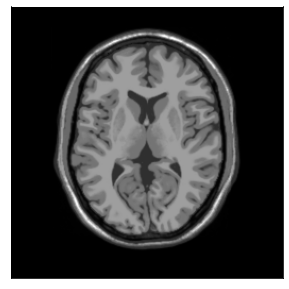

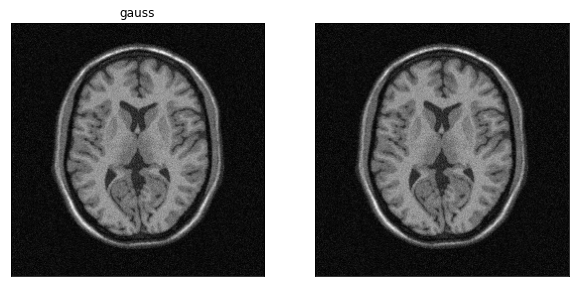

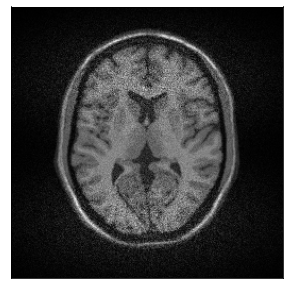

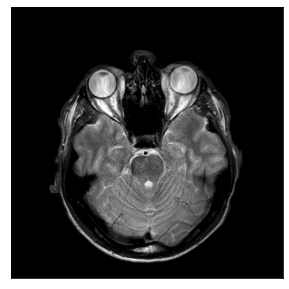

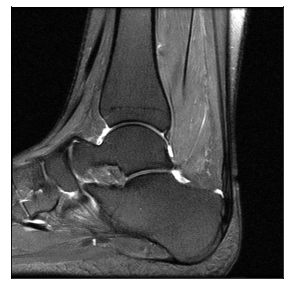

In [2]:
def wart(I:np.ndarray, filtr: np.ndarray):
    return np.sum(I*filtr)

def gauss(I,W:int,v1:float, v2:float):
    filtr = np.zeros((W,W))
    d=W//2
    iN = I.copy()
    (X,Y) = I.shape
    for x in range(d,X-d):
        for y in range(d,Y-d):
            for i in range(W):
                for j in range(W):
                    dV = np.abs(int(I[x+i-d, y+j-d]) - int(I[x,y]))
            
    return iN

W=5
v1 = 2
v2 = 2
plt.figure(figsize=(5,5))
plt.imshow(gauss(noisefree,W,v1, v2), cmap ="gray")
plt.xticks([]), plt.yticks([])
plt.show()
plt.figure(figsize=(10,5))
v1 = 2
v2= 20
plt.subplot(1,2,1)
filt = gauss(noisy1,W,v1,v2)
plt.imshow(filt, cmap ="gray")
plt.title('gauss')
plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(noisy1, cmap ="gray")
plt.xticks([]), plt.yticks([])
plt.show()



plt.figure(figsize=(5,5))
v1 = 6
v2 = 2
plt.imshow(gauss(noisy2,W,v1,v2), cmap ="gray")
plt.xticks([]), plt.yticks([])
plt.show()
v1 = 4
v2 = 4
plt.figure(figsize=(5,5))
plt.imshow(gauss(noisy3,W,v1,v2), cmap ="gray")
plt.xticks([]), plt.yticks([])
plt.show()
v1 = 2
v2 = 4
plt.figure(figsize=(5,5))
plt.imshow(gauss(noisy4,W,v1,v2), cmap ="gray")
plt.xticks([]), plt.yticks([])
plt.show()




### Filtracja bilateralna

1. Zdefiniuj dodatkowy parametr: wariancję $\delta_R$.
3. Wykonaj kopię obrazu wejściowego: `IBilateral = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentami funkcji są aktualnie przetwarzane okno, współczynniki filtra gausowskiego (takie same jak wcześniej) i wariancja $\delta_R$.
7. Oblicz odległość w przeciwdziedzinie (dla wartości pikseli).
8. Oblicz funkcję Gaussa dla obliczonych odległości z zadanym parametrem.
9. Wykonaj normalizację obliczonych współczynników.
10. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
11. Wyświetl wynik filtracji.
12. Porównaj wynik z obrazem oryginalnym.

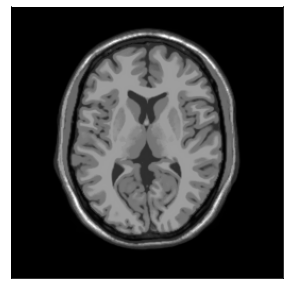

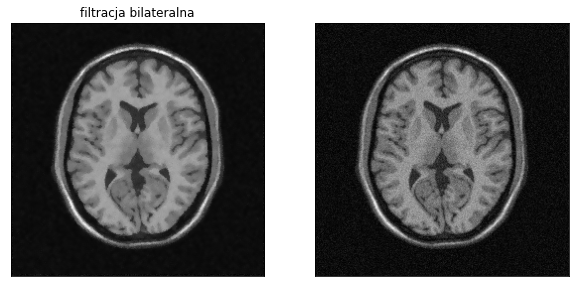

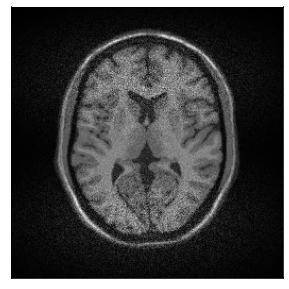

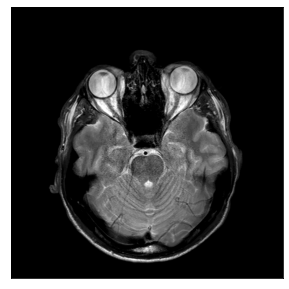

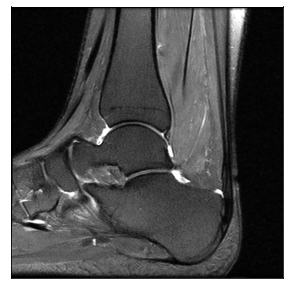

In [3]:
def wart(I:np.ndarray, filtr: np.ndarray):
    return np.sum(I*filtr)

def bilat(I,W:int,war1:float, war2:float):
    filter = np.zeros((W,W))
    d=W//2
    filtrwart = np.zeros((W,W))
    I_N = I.copy()
    for i in range(W):
        for j in range(W): 
            dx = abs(d - i)
            dy = abs(d - j)
            dr2 = dx**2 + dy**2
            filter[i][j] = np.e**(-dr2 / (2*war1**2))
    filter/= np.sum(filter)
    (X,Y) = I.shape
    for x in range(d,X-d):
        for y in range(d,Y-d):
            for i in range(W):
                for j in range(W):
                    dV = np.abs(int(I[x+i-d, y+j-d]) - int(I[x,y]))
                    filtrwart[i][j] = np.e**(-dV**2 / (2*war2**2))
            filtrwart*=filter
            if np.sum(filtrwart)>0:
                filtrwart/= np.sum(filtrwart)
            I_N[x,y] = wart(I[x-d:x+d+1, y-d:y+d+1],filtrwart )
    return I_N
W=5
war1 = 2
war2 = 2
plt.figure(figsize=(5,5))
plt.imshow(bilat(noisefree,W,war1, war2), cmap ="gray")
plt.xticks([]), plt.yticks([])
plt.show()
plt.figure(figsize=(10,5))
war1 = 2
war2=20
plt.subplot(1,2,1)
plt.imshow(bilat(noisy1,W,war1,war2), cmap ="gray")
plt.title('filtracja bilateralna')
plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(noisy1, cmap ="gray")
plt.xticks([]), plt.yticks([])
plt.show()
plt.figure(figsize=(5,5))
war1 = 6
war2 = 2
plt.imshow(bilat(noisy2,W,war1,war2), cmap ="gray")
plt.xticks([]), plt.yticks([])
plt.show()
war1 = 4
war2 = 4
plt.figure(figsize=(5,5))
plt.imshow(bilat(noisy3,W,war1,war2), cmap ="gray")
plt.xticks([]), plt.yticks([])
plt.show()
war1 = 2
war2 = 4
plt.figure(figsize=(5,5))
plt.imshow(bilat(noisy4,W,war1,war2), cmap ="gray")
plt.xticks([]), plt.yticks([])
plt.show()